In [1]:
import torch
import torch.distributions as dist
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [62]:
batch_size = 512
dl_train = torch.utils.data.DataLoader(
    datasets.FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True),
batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(
    datasets.FashionMNIST('.', train=False, transform=transforms.ToTensor(), download=True),
batch_size=batch_size * 3, shuffle=False)

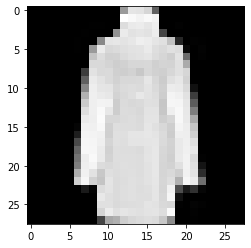

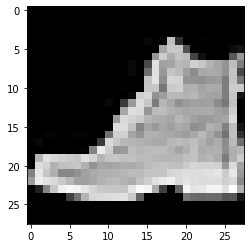

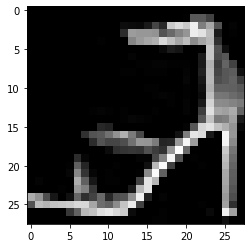

In [63]:
batch, _ = next(iter(dl_train))

for i in range(3):
    plt.imshow(1 - batch[i].view(28, 28).numpy(), cmap='Greys')
    plt.show()
    
del batch

In [64]:
def middle_size(size_in, size_out):
    """
    Make a funnel with regard to the number of weights.
    """
    return (size_in - size_out) // 2 + size_out

class VAE(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.latent_size = latent_size 
        size = middle_size(784, self.latent_size)
        
        # Encode into gaussian paramaters. First part of vector is mu and second part log variance
        self.encoder = nn.Sequential(
            nn.Linear(784, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, latent_size * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, size),
            nn.ReLU(),
            nn.Linear(size, 784),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)  # unit gaussian
        z = mu + eps * std 
        return z

    def forward(self, x):
        z_theta = self.encoder(x)
        mu = z_theta[:, :self.latent_size]
        log_var = z_theta[:, self.latent_size:]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var, z

In [73]:
def loss_function(reconstruction_x, x, mu, log_var, z, mc_kl=True, beta=1.):
    likelihood = F.binary_cross_entropy(reconstruction_x, x.view(-1, 784), reduction='sum')
    
    # is worse then the analyitical solution, but is better for comparing ELBO with Flows
    if mc_kl:
        log_prior = dist.Normal(0, 1).log_prob(z)
        log_p_q = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z)
        kl = (log_p_q - log_prior).sum()
    else: 
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

    return (likelihood + beta * kl) / x.shape[0]

In [74]:
def evaluate_test(device='cuda'):
    avg_loss = 0
    with torch.no_grad():
        for (x, _) in dl_test:
            x = x.to(device).view(-1, 784)
            reconstruction_x, mu, log_var, z = m(x)
            avg_loss += loss_function(reconstruction_x, x, mu, log_var, z, 1)
    return (avg_loss / len(dl_test.dataset)).item()
  
m = VAE(latent_size)
m.cuda()
evaluate_test()

0.3865041732788086

In [75]:
latent_size = 32
m = VAE(latent_size)
m.cuda()

vae_loss = []

def log_training(batch_idx, x, loss):
    if batch_idx % 400 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(x), len(dl.dataset),
            100. * batch_idx / len(dl),
            loss.item() / len(x)))

def train(epoch, m, device, optimizer, beta):
    m.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(dl_train):
        x = x.to(device).view(-1, 784)
        
        optim.zero_grad()
        reconstruction_x, mu, log_var, z = m(x)
        loss = loss_function(reconstruction_x, x, mu, log_var, z, beta)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(dl_train.dataset)
    print('Epoch: {:3d}'
          '\tAverage loss: {:.4f}'
          '\tAverage test loss: {:.4f}'
          '\tBeta: {:.3f}'.format(epoch, avg_loss, evaluate_test(), beta))
    vae_loss.append(avg_loss)


# optim = torch.optim.Adam(m.parameters(), 5e-4)

# for epoch in range(1, 111):
#     beta = min(1, 1 / 90 * epoch)
#     train(epoch, m, 'cuda', optim, beta)
    
optim = torch.optim.Adam(m.parameters(), 1e-2)

for epoch in range(1, 50):
    beta = 1.
    train(epoch, m, 'cuda', optim, beta)

Epoch:   1	Average loss: 0.6467	Average test loss: 0.2048	Beta: 1.000
Epoch:   2	Average loss: 0.5570	Average test loss: 0.1945	Beta: 1.000
Epoch:   3	Average loss: 0.5292	Average test loss: 0.1865	Beta: 1.000
Epoch:   4	Average loss: 0.5123	Average test loss: 0.1829	Beta: 1.000
Epoch:   5	Average loss: 0.5071	Average test loss: 0.1807	Beta: 1.000
Epoch:   6	Average loss: 0.5020	Average test loss: 0.1797	Beta: 1.000
Epoch:   7	Average loss: 0.4995	Average test loss: 0.1791	Beta: 1.000
Epoch:   8	Average loss: 0.4980	Average test loss: 0.1784	Beta: 1.000
Epoch:   9	Average loss: 0.4963	Average test loss: 0.1785	Beta: 1.000
Epoch:  10	Average loss: 0.4959	Average test loss: 0.1778	Beta: 1.000
Epoch:  11	Average loss: 0.4949	Average test loss: 0.1776	Beta: 1.000
Epoch:  12	Average loss: 0.4937	Average test loss: 0.1780	Beta: 1.000
Epoch:  13	Average loss: 0.4939	Average test loss: 0.1784	Beta: 1.000
Epoch:  14	Average loss: 0.4935	Average test loss: 0.1787	Beta: 1.000
Epoch:  15	Average l

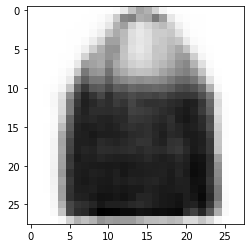

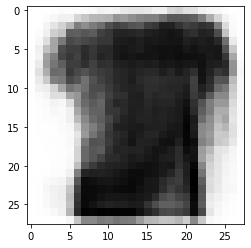

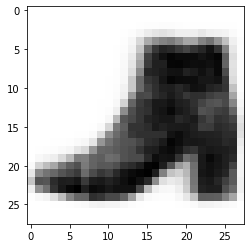

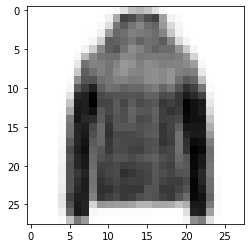

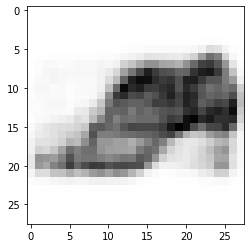

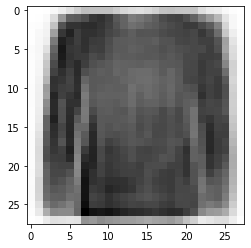

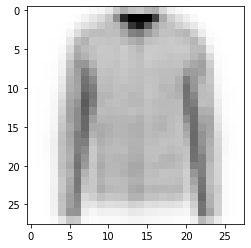

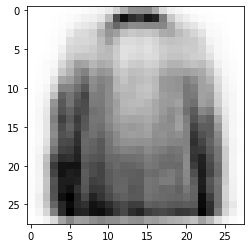

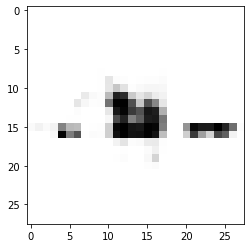

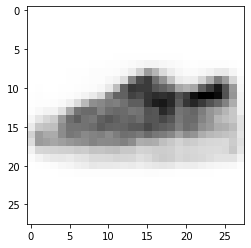

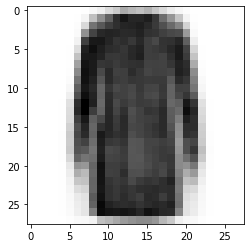

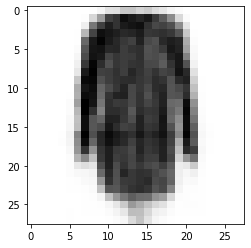

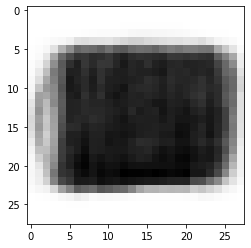

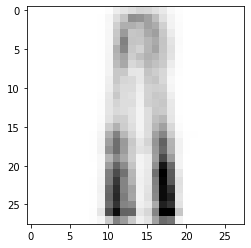

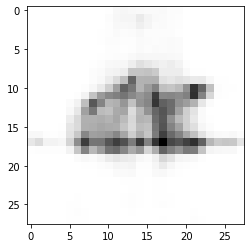

In [76]:
def show_samples(m, n=15, device='cuda'):
    with torch.no_grad():
        # take n samples
        sample = torch.randn(n, latent_size).to(device)
        sample = m.decoder(sample).cpu().view(-1, 28, 28)
        
    for i in range(sample.shape[0]):
        plt.imshow(sample[i].view(28, 28), cmap='Greys')
        plt.show()
        
show_samples(m)